In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
matplotlib.style.use('ggplot')

### Import data

In [237]:
sym = pd.read_csv('./data/2021VAERSSYMPTOMS.csv')
vax = pd.read_csv('./data/2021VAERSVAX.csv')
info = pd.read_csv('./data/2021VAERSDATA.csv', encoding = "ISO-8859-1")

In [238]:
sym = sym.drop_duplicates(subset=['VAERS_ID'])
vax = vax.drop_duplicates(subset=['VAERS_ID'])
info = info.drop_duplicates(subset=['VAERS_ID'])

In [239]:
sym.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916710,Appendicitis,23.1,Band neutrophil percentage increased,23.1,Surgery,23.1,White blood cell count increased,23.1,NaN,NaN


In [240]:
vax.head(1)

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916710,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))


In [241]:
info.head(1)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916710,01/01/2021,MO,23.0,23.0,NaN,F,NaN,"Acute appendicitis, onset morning of 1/1/2021 ...",NaN,...,NaN,Hypothyroidism,NaN,NaN,2,01/01/2021,NaN,NaN,Y,NKDA


### Drop unnecessary columns

In [242]:
sym = sym.drop(columns=['SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5'])
sym = sym.replace(np.nan, 'unknown')
sym.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916710,Appendicitis,Band neutrophil percentage increased,Surgery,White blood cell count increased,unknown


Drop unnecessary columns and remove instances that are not Covid-10 vaccines.

In [243]:
i = vax[(vax.VAX_TYPE != 'COVID19')].index
vax = vax.drop(i)
vax = vax.drop(columns=['VAX_LOT', 'VAX_ROUTE', 'VAX_SITE', 'VAX_TYPE', 'VAX_DOSE_SERIES', 'VAX_NAME'])
vax = vax.replace(np.nan, 'unknown')
vax.head(1)

,VAERS_ID,VAX_MANU
0,916710,MODERNA


In [244]:
info = info.drop(columns=['RECVDATE', 'STATE', 'CAGE_YR', 'CAGE_MO', 'RPT_DATE', 'SYMPTOM_TEXT', 'DATEDIED', 'ER_VISIT', 
                  'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 
                  'V_ADMINBY', 'V_FUNDBY', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'ER_ED_VISIT',
                  'DIED', 'L_THREAT', 'DISABLE', 'CUR_ILL', 'PRIOR_VAX', 'BIRTH_DEFECT'])
info = info.replace(np.nan, 'unknown')
info.head(1)

,VAERS_ID,AGE_YRS,SEX,OTHER_MEDS,HISTORY,ALLERGIES
0,916710,23,F,Synthroid,Hypothyroidism,NKDA


### Use tfidfs

In [247]:
df = info.merge(vax, how='inner', on='VAERS_ID')
df = df.merge(sym, how='inner', on='VAERS_ID')

In [248]:
# Define a count vectorizer
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(df['HISTORY'].values)

# # Define a tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidfs = tfidf_vectorizer.fit_transform(df['HISTORY'].values)

In [249]:
X = tfidfs
y = df['SYMPTOM1'].values

classifier = MultinomialNB()
classifier.fit(X, y)

# km = KMeans(n_clusters=21, random_state=0)
# km.fit(x);

MultinomialNB()

In [250]:
example_history = ['insomnia', 'diabetes']

In [251]:
example_counts = tfidf_vectorizer.transform(example_history)
predictions = classifier.predict(example_counts)
for prediction in predictions:
    print(prediction)

Chills
Death


### Transform the dataset into a numerical dataframe

In [ ]:
df = pd.get_dummies(df)
# df = df.drop(columns=['VAERS_ID'])

In [ ]:
frequent_itemsets = apriori(df, min_support=0.2, use_colnames=True, max_len=3)

In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

#### Generate top _medical history_, _medication_ and _allergy_ key words

In [245]:
# Define a count vectorizer
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(info['HISTORY'].values)

# # Define a tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidfs = tfidf_vectorizer.fit_transform(info['HISTORY'].values)

In [ ]:
count_vectorizer.vocabulary_ 

In [ ]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(info['OTHER_MEDS'].values)
count_vectorizer.vocabulary_ 

In [ ]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(info['ALLERGIES'].values)
count_vectorizer.vocabulary_ 

In [ ]:
vax.VAX_MANU.unique()

In [96]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(sym['SYMPTOM1'].values)

In [137]:
sorted_keys = sorted(count_vectorizer.vocabulary_.items(), key=lambda x: x[1], reverse=True)

### High frequent symptoms:

In [126]:
list_symptom = ['zoster', 'vomiting', 'urticaria', 'urobilinogen', 'tuberculosis', 'toothache', 'tinnitus', 
                'thyroiditis', 'thrombosis', 'thrombocytopenia', 'tachypnoea', 'systolic', 'sweat', 'stomatitis',
                'rhinorrhoea', 'pyrexia', 'pulseless', 'oedema', 'neutrophilia', 'neuralgia']

In [131]:
symptom = pd.DataFrame(sorted_keys, columns =['Symptom', 'Frequency'])
symptom['Frequency'] = pd.to_numeric(symptom['Frequency'])
 
i = symptom[(symptom.Frequency < 700)].index
symptom = symptom.drop(i)

i = []
for index, row in symptom.iterrows():
    if row['Symptom'] in list_symptom:
        i.append(index)

high_fre_sym = symptom.loc[i]
high_fre_sym.head(2)

,Symptom,Frequency
0,zoster,1181
19,vomiting,1162


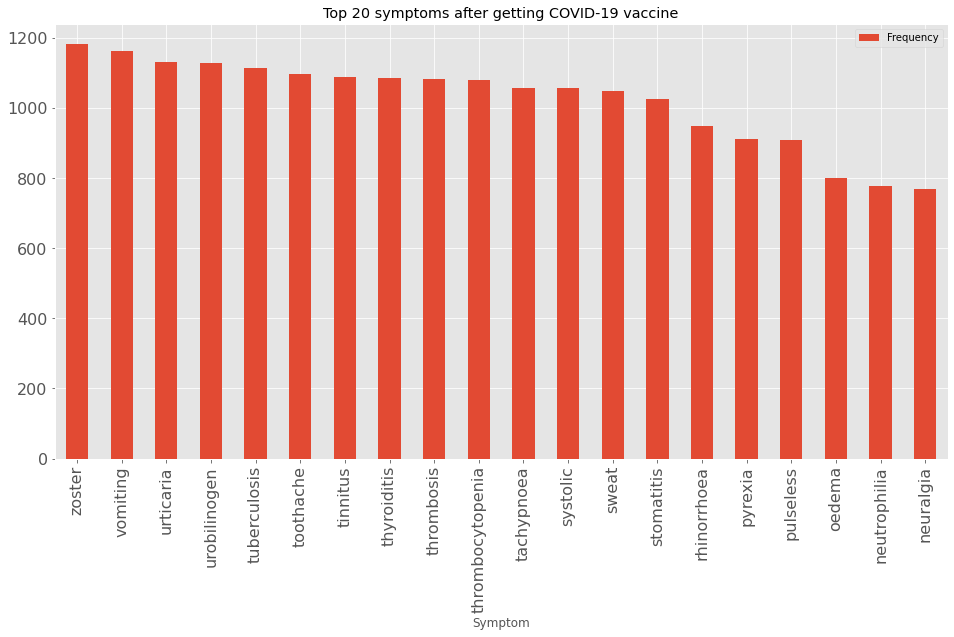

In [136]:
title='Top 20 symptoms after getting COVID-19 vaccine'
ax = high_fre_sym.plot.bar(x='Symptom', y='Frequency', rot=90, figsize = (16,8), title=title, fontsize = 16)

#### Add new columns using those key words

In [174]:
list_history = ['hypothyroidism', 'rheumatoid', 'arthritis', 'insomnia', 'cholesterol', 'asthma', 'migraines', 'lymphoma',
        'diabetes', 'depression', 'obesity', 'anemia', 'dermatitis', 'dysmenorrhea', 'neuropathy', 'fibromyalgia',
        'disabilities', 'autism', 'prostate', 'gallstones']

In [175]:
for i in list_history:
    val = []
    for index, row in info.iterrows():
        if i in row['HISTORY']: 
            val.append(1)
        else:
            val.append(0)
    info[i] = val

In [176]:
info.head(1)

,VAERS_ID,AGE_YRS,SEX,OTHER_MEDS,HISTORY,ALLERGIES,hypothyroidism,rheumatoid,arthritis,insomnia,...,obesity,anemia,dermatitis,dysmenorrhea,neuropathy,fibromyalgia,disabilities,autism,prostate,gallstones
0,916710,23,F,Synthroid,Hypothyroidism,NKDA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
list_medication = ['Synthroid', 'phenobarbital', 'hydroxychloroquine', 'famotidine', 'acetaminophen', 'propranolol', 'Zoloft',
         'lisinopril', 'crestor', 'protonix', 'melatonin', 'estradiol', 'topiramate', 'sumatriptan', 'multivitamin',
         'novolog', 'lantus', 'gabapentin', 'glusosamine', 'chondroitin']

In [178]:
for i in list_medication:
    val = []
    for index, row in info.iterrows():
        if i in row['OTHER_MEDS']: 
            val.append(1)
        else:
            val.append(0)
    info[i] = val

In [179]:
info.head(1)

,VAERS_ID,AGE_YRS,SEX,OTHER_MEDS,HISTORY,ALLERGIES,hypothyroidism,rheumatoid,arthritis,insomnia,...,melatonin,estradiol,topiramate,sumatriptan,multivitamin,novolog,lantus,gabapentin,glusosamine,chondroitin
0,916710,23,F,Synthroid,Hypothyroidism,NKDA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
list_allergy = ['bee', 'codeine', 'sulfa', 'shellfish', 'peanuts', 'soy', 'oysters', 'crab', 'lobster', 'penicillin',
                'eurythromyacin', 'Prozac', 'dust', 'mites', 'dairy', 'egg', 'seafood', 'antibiotics', 'milk', 'coin']

In [181]:
for i in list_allergy:
    val = []
    for index, row in info.iterrows():
        if i in row['ALLERGIES']: 
            val.append(1)
        else:
            val.append(0)
    info[i] = val

In [182]:
info.head(1)

,VAERS_ID,AGE_YRS,SEX,OTHER_MEDS,HISTORY,ALLERGIES,hypothyroidism,rheumatoid,arthritis,insomnia,...,eurythromyacin,Prozac,dust,mites,dairy,egg,seafood,antibiotics,milk,coin
0,916710,23,F,Synthroid,Hypothyroidism,NKDA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
list_symptom = ['zoster', 'vomiting', 'urticaria', 'urobilinogen', 'tuberculosis', 'toothache', 'tinnitus', 
                'thyroiditis', 'thrombosis', 'thrombocytopenia', 'tachypnoea', 'systolic', 'sweat', 'stomatitis',
                'rhinorrhoea', 'pyrexia', 'pulseless', 'oedema', 'neutrophilia', 'neuralgia']

In [185]:
d = dict([(y,x+1) for x,y in enumerate(sorted(set(list_symptom)))])

In [186]:
def check_value_exist(test_dict, value):
    do_exist = False
    for key, val in test_dict.items():
        if key == value:
            do_exist = True
    return do_exist

In [187]:
v = []
for index, row in sym.iterrows():
    do_exist = False
    for key, val in d.items():
        if key in row['SYMPTOM1']:
            v.append(val)
            do_exist = True
            break
    if not do_exist:
        v.append(0)
sym['SYMPTOM'] = v

In [188]:
sym.head(1)

,VAERS_ID,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,SYMPTOM
0,916710,Appendicitis,Band neutrophil percentage increased,Surgery,White blood cell count increased,unknown,0


In [ ]:
info.AGE_YRS.unique()

### Clean up

In [189]:
info = info.drop(columns=['OTHER_MEDS', 'HISTORY', 'ALLERGIES'])
info.head(1)

,VAERS_ID,AGE_YRS,SEX,hypothyroidism,rheumatoid,arthritis,insomnia,cholesterol,asthma,migraines,...,eurythromyacin,Prozac,dust,mites,dairy,egg,seafood,antibiotics,milk,coin
0,916710,23,F,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
info.SEX.unique()

array(['F', 'M', 'U'], dtype=object)

In [191]:
val = []
for index, row in info.iterrows():
    if row['SEX'] == 'F':
        val.append(0)
    elif row['SEX'] == 'M':
        val.append(1)
    else:
        val.append(2)
info['SEX'] = val

In [192]:
info.head(1)

,VAERS_ID,AGE_YRS,SEX,hypothyroidism,rheumatoid,arthritis,insomnia,cholesterol,asthma,migraines,...,eurythromyacin,Prozac,dust,mites,dairy,egg,seafood,antibiotics,milk,coin
0,916710,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
for index, row in info.iterrows():
    if row['AGE_YRS'] == 'unknown':
        info = info.drop([index])

In [194]:
info.AGE_YRS.unique()

array([23.0, 68.0, 55.0, 52.0, 78.0, 40.0, 37.0, 39.0, 0.33, 82.0, 43.0,
       35.0, 30.0, 60.0, 41.0, 65.0, 76.0, 86.0, 53.0, 22.0, 36.0, 24.0,
       38.0, 79.0, 90.0, 18.0, 47.0, 49.0, 28.0, 54.0, 33.0, 32.0, 67.0,
       64.0, 61.0, 50.0, 34.0, 44.0, 58.0, 26.0, 56.0, 31.0, 62.0, 4.0,
       85.0, 66.0, 45.0, 27.0, 48.0, 46.0, 59.0, 57.0, 29.0, 89.0, 80.0,
       51.0, 73.0, 63.0, 94.0, 74.0, 42.0, 93.0, 25.0, 69.0, 70.0, 100.0,
       96.0, 81.0, 19.0, 16.0, 7.0, 92.0, 104.0, 21.0, 77.0, 88.0, 87.0,
       17.0, 75.0, 71.0, 20.0, 11.0, 0.58, 84.0, 91.0, 9.0, 1.08, 1.0,
       3.0, 95.0, 72.0, 83.0, 99.0, 98.0, 101.0, 97.0, 105.0, 5.0, 1.42],
      dtype=object)

In [195]:
val = []
for index, row in vax.iterrows():
    if 'MODERNA' in row['VAX_MANU']:
        val.append(0)
    elif 'PFIZER' or 'BIONTECH' in row['VAX_MANU']:
        val.append(1)
    else:
        val.append(2)
vax['VAX_MANU'] = val
vax.head(1)

,VAERS_ID,VAX_MANU
0,916710,0


In [196]:
sym = sym.drop(columns=['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5'])
sym.head(1)

,VAERS_ID,SYMPTOM
0,916710,0


### Merge three dataframe

In [197]:
df = info.merge(vax, how='inner', on='VAERS_ID')
df = df.merge(sym, how='inner', on='VAERS_ID')
df.head(1)

,VAERS_ID,AGE_YRS,SEX,hypothyroidism,rheumatoid,arthritis,insomnia,cholesterol,asthma,migraines,...,dust,mites,dairy,egg,seafood,antibiotics,milk,coin,VAX_MANU,SYMPTOM
0,916710,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.hypothyroidism.unique()

In [198]:
df = df.drop(columns=['VAERS_ID'])
df.head(2)

,AGE_YRS,SEX,hypothyroidism,rheumatoid,arthritis,insomnia,cholesterol,asthma,migraines,lymphoma,...,dust,mites,dairy,egg,seafood,antibiotics,milk,coin,VAX_MANU,SYMPTOM
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,23,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [199]:
from sklearn.model_selection import train_test_split
y = df["SYMPTOM"]
X = df.drop(["SYMPTOM"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [200]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [201]:
xt = X[103:105]
reg.predict(xt)

array([0.05894318, 0.04717102])

### Cluster the the data using k-Means clustering

In [202]:
df.head(1)

,AGE_YRS,SEX,hypothyroidism,rheumatoid,arthritis,insomnia,cholesterol,asthma,migraines,lymphoma,...,dust,mites,dairy,egg,seafood,antibiotics,milk,coin,VAX_MANU,SYMPTOM
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


For a given patient, find the closest set of patients to him/her in the dataset

In [203]:
x = df.drop(["SYMPTOM"], axis=1)
y = df["SYMPTOM"]

In [204]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=21, random_state=0)
km.fit(x);

In [205]:
for index, row in df.iterrows():
    if row['SYMPTOM'] == 20:
        print(index)

2770
3130
3238
3276


In [209]:
test_list = df.drop(['SYMPTOM'], axis=1).iloc[2770].array
km.predict([test_list])

array([19], dtype=int32)

### Separate dataset using vaccine type

Train two models 
- dataset with Moderna
- dataset with BioNtech  
  
Given a patient info --> Tom_info  
bring it into two models, if Moderna_model has better result, then we recommand Moderana to Tom.

In [224]:
i = df[(df.VAX_MANU == 1)].index
MODERNA_df = df.drop(i)

i = df[(df.VAX_MANU == 0)].index
BIONTECH_df = df.drop(i)

In [230]:
x = MODERNA_df.drop(["SYMPTOM"], axis=1)
y = MODERNA_df["SYMPTOM"]

In [231]:
km = KMeans(n_clusters=21, random_state=0)
km.fit(x);

In [232]:
for index, row in MODERNA_df.iterrows():
    if row['SYMPTOM'] == 3:
        print(index)

325
1023
1575
1942
2233
2729
3036


In [234]:
test_list = df.drop(['SYMPTOM'], axis=1).iloc[3036].array
km.predict([test_list])

In [217]:
x = BIONTECH_df.drop(["SYMPTOM"], axis=1)
y = BIONTECH_df["SYMPTOM"]

In [218]:
km = KMeans(n_clusters=21, random_state=0)
km.fit(x);

In [220]:
test_list = df.drop(['SYMPTOM'], axis=1).iloc[3036].array
km.predict([test_list])

array([3], dtype=int32)

In [221]:
len(MODERNA_df)

1664

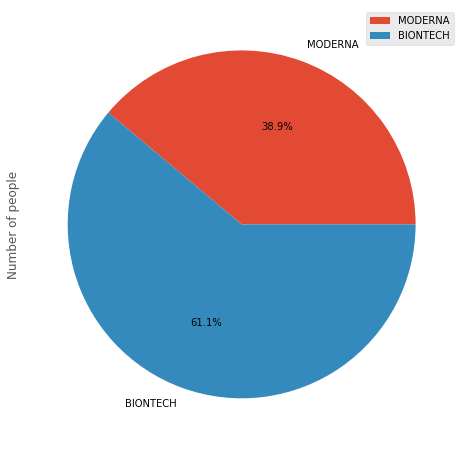

In [222]:
df = pd.DataFrame({'Vaccine_type': ['MODERNA', 'BIONTECH'],
                   'Number of people': [len(MODERNA_df), len(BIONTECH_df)]},
                  index=['MODERNA', 'BIONTECH'])
plot = df.plot.pie(y='Number of people', figsize=(8, 8), autopct='%.1f%%')

## World Vaccination Progress

In [5]:
data = pd.read_csv('./data/country_vaccinations.csv')

In [6]:
data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,http://www.xinhuanet.com/english/asiapacific/2...


### Pre-process the data

In [7]:
data = data.drop(columns=['iso_code', 'daily_vaccinations_raw', 'people_vaccinated', 'people_vaccinated_per_hundred',
                         'daily_vaccinations_per_million', 'source_name', 'source_website'])

In [8]:
data.head()

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
0,Afghanistan,2021-02-22,0.0,NaN,NaN,0.0,NaN,Oxford/AstraZeneca
1,Afghanistan,2021-02-23,NaN,NaN,1367.0,NaN,NaN,Oxford/AstraZeneca
2,Afghanistan,2021-02-24,NaN,NaN,1367.0,NaN,NaN,Oxford/AstraZeneca
3,Afghanistan,2021-02-25,NaN,NaN,1367.0,NaN,NaN,Oxford/AstraZeneca
4,Afghanistan,2021-02-26,NaN,NaN,1367.0,NaN,NaN,Oxford/AstraZeneca


In [9]:
data = data.dropna()
data.head()

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
53,Albania,2021-02-09,1127.0,438.0,82.0,0.04,0.02,Pfizer/BioNTech
61,Albania,2021-02-17,1701.0,611.0,72.0,0.06,0.02,Pfizer/BioNTech
62,Albania,2021-02-18,3049.0,611.0,254.0,0.11,0.02,Pfizer/BioNTech
66,Albania,2021-02-22,6728.0,655.0,739.0,0.23,0.02,Pfizer/BioNTech
161,Andorra,2021-03-08,3611.0,1172.0,108.0,4.67,1.52,Pfizer/BioNTech


In [10]:
len(data.country.unique())

82

In [11]:
prev = ""
prevIdx = 0
for index, row in data.iterrows():
    if (row['country'] == prev):
        data = data.drop([prevIdx])
    prevIdx = index
    prev = row['country']

In [12]:
data.head()

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
66,Albania,2021-02-22,6728.0,655.0,739.0,0.23,0.02,Pfizer/BioNTech
168,Andorra,2021-03-15,8363.0,1265.0,679.0,10.82,1.64,Pfizer/BioNTech
354,Argentina,2021-03-24,3328933.0,634479.0,94404.0,7.37,1.40,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V"
479,Austria,2021-03-23,1354694.0,341362.0,31533.0,15.04,3.79,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
635,Bahrain,2021-03-24,694679.0,242128.0,13890.0,40.83,14.23,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm..."


In [13]:
top_10 = data.sort_values(by=['total_vaccinations'], ascending=False).head(10)
top_10

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
7882,United States,2021-03-24,130473853.0,46365515.0,2490889.0,39.01,13.86,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
3438,India,2021-03-24,53145709.0,8299171.0,2286065.0,3.85,0.60,"Covaxin, Oxford/AstraZeneca"
7787,United Kingdom,2021-03-23,31186362.0,2532839.0,593384.0,45.94,3.73,"Oxford/AstraZeneca, Pfizer/BioNTech"
2369,England,2021-03-23,26226604.0,1820530.0,501259.0,46.59,3.23,"Oxford/AstraZeneca, Pfizer/BioNTech"
1112,Brazil,2021-03-24,15943964.0,3795195.0,465953.0,7.50,1.79,"Oxford/AstraZeneca, Sinovac"
7501,Turkey,2021-03-24,13969867.0,5836824.0,261089.0,16.56,6.92,Sinovac
2784,Germany,2021-03-23,11447546.0,3516966.0,217939.0,13.66,4.20,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
6239,Russia,2021-03-22,10600000.0,4300000.0,408772.0,7.26,2.95,"EpiVacCorona, Sputnik V"
3783,Israel,2021-03-24,9859591.0,4655933.0,42521.0,113.91,53.79,"Moderna, Pfizer/BioNTech"
3509,Indonesia,2021-03-23,9330853.0,2941016.0,449308.0,3.41,1.08,Sinovac


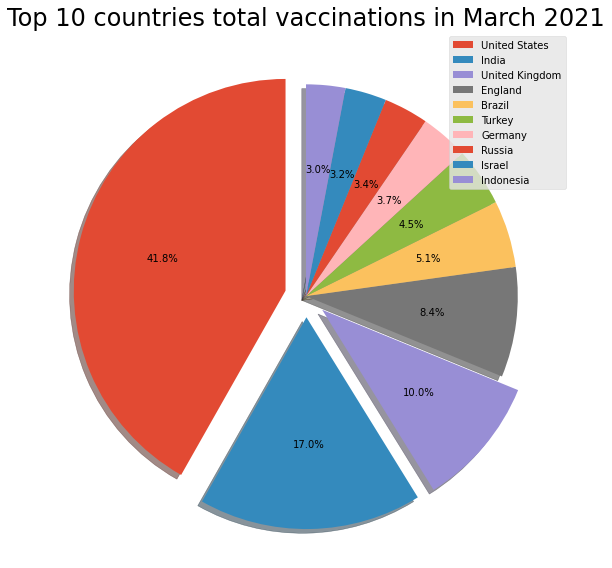

In [14]:
labels = top_10['country']
explode =(0.1,0.1,0.1,0,0,0,0,0,0,0) 
fig, ax1 = plt.subplots(figsize = (16,8)) 
ax1.pie(top_10['total_vaccinations'], explode = explode, startangle=90, autopct='%.1f%%', shadow = True) 
plt.title('Top 10 countries total vaccinations in March 2021', fontsize = 24) 
ax1.legend(labels, loc = 'upper right') 
plt.tight_layout() 
plt.show()

In [15]:
top_10 = data.sort_values(by=['people_fully_vaccinated'], ascending=False).head(10)
top_10

,country,date,total_vaccinations,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,vaccines
7882,United States,2021-03-24,130473853.0,46365515.0,2490889.0,39.01,13.86,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
3438,India,2021-03-24,53145709.0,8299171.0,2286065.0,3.85,0.60,"Covaxin, Oxford/AstraZeneca"
7501,Turkey,2021-03-24,13969867.0,5836824.0,261089.0,16.56,6.92,Sinovac
3783,Israel,2021-03-24,9859591.0,4655933.0,42521.0,113.91,53.79,"Moderna, Pfizer/BioNTech"
6239,Russia,2021-03-22,10600000.0,4300000.0,408772.0,7.26,2.95,"EpiVacCorona, Sputnik V"
1112,Brazil,2021-03-24,15943964.0,3795195.0,465953.0,7.50,1.79,"Oxford/AstraZeneca, Sinovac"
2784,Germany,2021-03-23,11447546.0,3516966.0,217939.0,13.66,4.20,"Moderna, Oxford/AstraZeneca, Pfizer/BioNTech"
1523,Chile,2021-03-24,9053912.0,3105216.0,176981.0,47.36,16.24,"Pfizer/BioNTech, Sinovac"
3509,Indonesia,2021-03-23,9330853.0,2941016.0,449308.0,3.41,1.08,Sinovac
5079,Morocco,2021-03-24,7128976.0,2844916.0,109749.0,19.31,7.71,"Oxford/AstraZeneca, Sinopharm/Beijing"


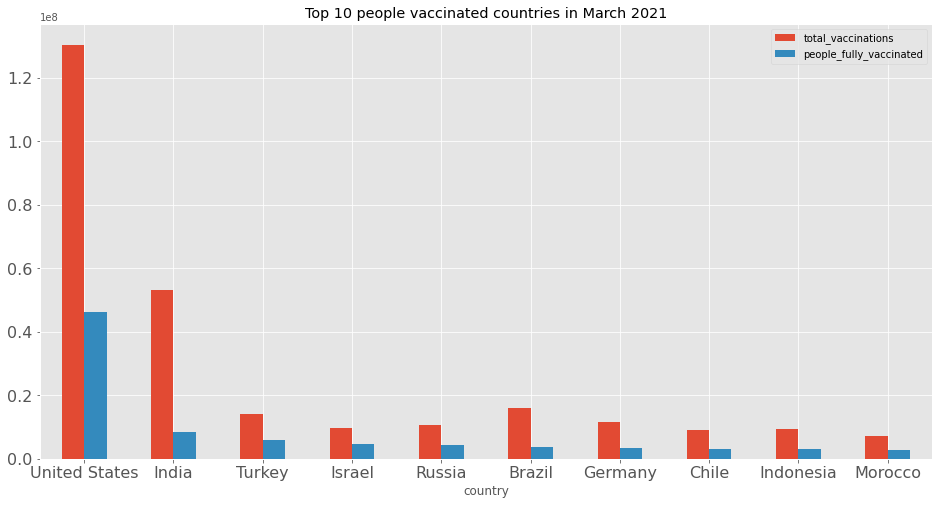

In [16]:
total = pd.Series(top_10['total_vaccinations']).array
people = pd.Series(top_10['people_fully_vaccinated']).array
index = top_10['country']
df = pd.DataFrame({'total_vaccinations': total,
                   'people_fully_vaccinated': people}, index=index)
ax = df.plot.bar(figsize = (16,8), rot=0, title='Top 10 people vaccinated countries in March 2021', fontsize = 16)

## COVID-19 Data

In [17]:
data = pd.read_csv('./data/owid-covid-data.csv')

In [18]:
data.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


### Remove unnecessary columns

In [19]:
data = data.drop(columns=['iso_code','new_cases_smoothed', 'new_deaths_smoothed', 'total_cases_per_million', 
                         'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                         'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million',
                         'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million',
                         'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 
                          'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 
                          'new_tests_smoothed_per_thousand', 'tests_per_case', 'tests_units', 
                          'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 
                          'people_fully_vaccinated_per_hundred', 'new_vaccinations_smoothed_per_million', 
                          'stringency_index', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
                         'male_smokers', 'life_expectancy', 'human_development_index'])
data.head(3)

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,...,new_vaccinations_smoothed,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
0,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5
1,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5
2,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,37.746,0.5


In [20]:
data = data.drop(columns=['new_vaccinations_smoothed', 'population'])

In [21]:
continent = data.groupby(['continent']).mean()
continent

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,total_vaccinations,...,people_fully_vaccinated,new_vaccinations,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
continent,,,,,,,,,,,,,,,,,,,,,
Africa,30071.523231,205.979526,825.100792,6.071010,0.942307,NaN,NaN,6.518545e+05,0.082784,6.037900e+05,...,4.420310e+05,32023.316514,102.257346,21.133552,3.686499,2.192317,5513.735645,33.687745,25.523281,1.507113
Asia,226594.964714,1480.877873,4671.390849,27.570584,1.018768,226.013514,936.720513,5.987552e+06,0.065658,3.893719e+06,...,1.661594e+06,159863.300823,556.465384,30.505164,6.556459,4.063116,22911.654487,5.614426,71.351462,2.918833
Europe,247119.426519,2144.245575,7595.414753,53.235665,1.095886,577.940571,3341.709589,4.448055e+06,0.075521,1.381458e+06,...,3.772454e+05,43723.640639,590.226774,42.100465,17.767155,11.810395,33588.882425,0.900025,93.997554,5.150841
North America,532425.163270,3951.428151,18112.732750,115.006025,1.018926,6437.532488,25729.744849,1.465798e+07,0.158382,9.457618e+06,...,6.008278e+06,345813.367788,190.691787,31.723324,8.894935,5.639149,18107.679858,5.537181,77.661818,2.305049
Oceania,3815.488111,16.621355,179.487923,0.790660,0.919219,NaN,NaN,2.022953e+06,0.002911,1.148970e+05,...,NaN,11898.139535,47.088526,29.585513,8.940578,5.504557,17932.677346,6.469168,48.091231,2.741078
South America,639198.063239,4476.066036,19125.778274,120.854716,1.112103,NaN,NaN,1.733534e+06,0.191698,1.881816e+06,...,6.209550e+05,83313.073418,24.397668,30.250178,8.312401,5.212252,13913.781167,2.832238,66.069064,2.103962


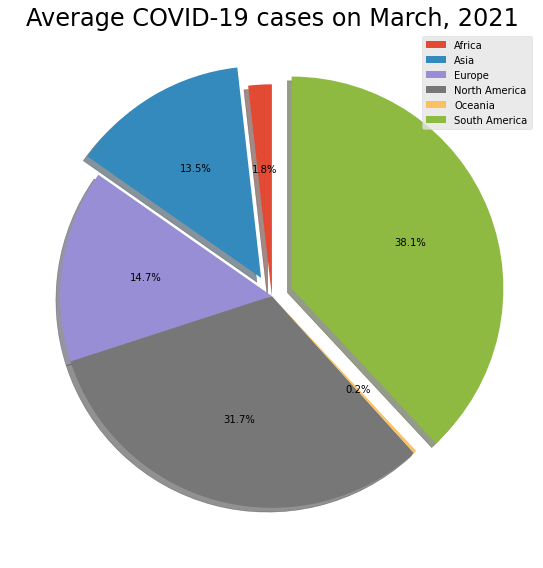

In [22]:
labels = continent.index
explode =(0,0.1,0,0,0,0.1) 
fig, ax1 = plt.subplots(figsize = (16,8)) 
ax1.pie(continent['total_cases'], explode = explode, startangle=90, autopct='%.1f%%', shadow = True) 
plt.title('Average COVID-19 cases on March, 2021', fontsize = 24) 
ax1.legend(labels, loc = 'upper right') 
plt.tight_layout() 
plt.show()

The top 3 continents are: North America, South America, and Africa, let's explore these continents next.

In [23]:
north_America = continent.loc[continent.index == 'North America']
north_America

,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,positive_rate,total_vaccinations,...,people_fully_vaccinated,new_vaccinations,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,handwashing_facilities,hospital_beds_per_thousand
continent,,,,,,,,,,,,,,,,,,,,,
North America,532425.16327,3951.428151,18112.73275,115.006025,1.018926,6437.532488,25729.744849,1.465798e+07,0.158382,9.457618e+06,...,6.008278e+06,345813.367788,190.691787,31.723324,8.894935,5.639149,18107.679858,5.537181,77.661818,2.305049
